In [4]:
import pandas as pd
# import pyreadstat
import matplotlib.pyplot as plt

from IPython.core.display import Image, display

# from samplics.datasets import load_nhanes2, load_nhanes2brr, load_nhanes2jk, load_nmihs
from samplics.estimation import TaylorEstimator, ReplicateEstimator

from slc_hunger_risk.config import data_dir

pd.options.mode.chained_assignment = None  # default='warn'

Data extraction following this example:
https://samplics.readthedocs.io/en/latest/tutorial/estimation.html

Data dictionary in appendix 4 of "Suriname COVID-19 survey"

In [8]:
# Load data
df = pd.read_csv(data_dir('raw', 'idb', 'Suriname-Survey-Data-May21', 'Data', 'suriname_covid19.csv'))
# df.columns


Income data:
- incjan, incjun = household income (SRD) in January, June 2020
- rmtjan, rmtjun = HH income in June/January from abroad
- spnjan, spnjun = Total HH spending in January/June 2020


In [9]:
# prepare dataset
df_base = df[["incjan", "incjun", "rmtjan", 'rmtjun', 'spnjan', 'spnjun', "great_par", 'weight2020', 'stratum', 'psu']]
df_base = df_base.drop(697) # remove ".a" entry in incjan
df_base = df_base.drop(216) # remove ".a" entry in incjun
df_base["great_par"] = df_base["great_par"].fillna(0.) # 1 = Great Paramaribo, 0 = coastal region

# string inputs to float
df_base["incjan"] = pd.to_numeric(df_base["incjan"], downcast="float")
df_base["incjun"] = pd.to_numeric(df_base["incjun"], downcast="float")

df_base["rmtjan"] = df_base["rmtjan"].replace('NO MONEY FROM ABROAD', '0')
df_base["rmtjun"] = df_base["rmtjun"].replace('NO MONEY FROM ABROAD', '0')
df_base["rmtjan"] = pd.to_numeric(df_base["rmtjan"], downcast="float")
df_base["rmtjun"] = pd.to_numeric(df_base["rmtjun"], downcast="float")

df_base["spnjan"] = pd.to_numeric(df_base["spnjan"], downcast="float")
df_base["spnjun"] = pd.to_numeric(df_base["spnjun"], downcast="float")


# df_base

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


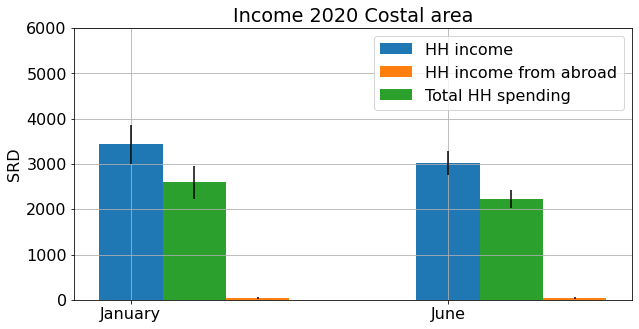

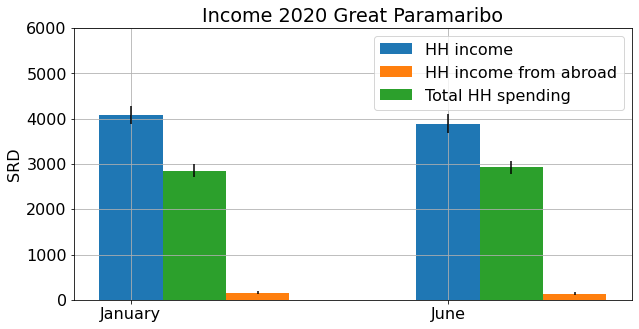

In [10]:
# Make plots
font = {'family' : 'normal',
        'size'   : 16}

plt.rc('font', **font)


area_txt = ['Costal area', 'Great Paramaribo']
for area in [0,1]:
    gpara = df_base[df_base['great_par'] == area]

    inc_mean = []; inc_std  = []
    for indicator in ["incjan", "incjun"]:
        mean_str = TaylorEstimator("mean")
        mean_str.estimate(
            y           = gpara[indicator],
            samp_weight = gpara["weight2020"],
            stratum     = gpara["stratum"],
            psu         = gpara["psu"] 
        )
        x = mean_str.to_dataframe()
        inc_std.append( x['_stderror'][0] )
        inc_mean.append(x['_estimate'][0])


    rmt_mean = []; rmt_std  = []
    for indicator in ["rmtjan", "rmtjun"]:
        mean_str = TaylorEstimator("mean")
        mean_str.estimate(
            y           = gpara[indicator],
            samp_weight = gpara["weight2020"],
            stratum     = gpara["stratum"],
            psu         = gpara["psu"] 
        )
        x = mean_str.to_dataframe()
        rmt_std.append( x['_stderror'][0] )
        rmt_mean.append(x['_estimate'][0])

    spn_mean = []; spn_std  = []
    for indicator in ["spnjan", "spnjun"]:
        mean_str = TaylorEstimator("mean")
        mean_str.estimate(
            y           = gpara[indicator],
            samp_weight = gpara["weight2020"],
            stratum     = gpara["stratum"],
            psu         = gpara["psu"] 
        )
        x = mean_str.to_dataframe()
        spn_std.append( x['_stderror'][0])
        spn_mean.append(x['_estimate'][0])
        
    plt.figure(figsize=(10,5))
    plt.bar([1,2], inc_mean, yerr = inc_std, align = 'center', width = 0.2, label = 'HH income') # income
    plt.bar([1.4,2.4], rmt_mean, yerr = rmt_std, align = 'center', width = 0.2, label = 'HH income from abroad') # income
    plt.bar([1.2,2.2], spn_mean, yerr = spn_std, align = 'center', width = 0.2, label = 'Total HH spending') # income
    plt.ylim([0, 6000])
    plt.legend()
    plt.ylabel('SRD')
    plt.grid(True)
    plt.xticks([1,2], ['January','June']); 
    plt.title('Income 2020 ' + area_txt[area])

In [12]:
# df_base.loc[df_base[param] == '.a'].index[0]

In [11]:
param = "rmtrcv" # received money from relatives abroad (jan-March 2020)
# param = "bnfjan" # governance assistance for HH in January
# param = "bnfnwr" # 

df_base = df[[param, "great_par", 'weight2020', 'stratum', 'psu']]
df_base["great_par"] = df_base["great_par"].fillna(0.) # 1 = Great Paramaribo, 0 = coastal region

df_base = df_base.drop(df_base.loc[df_base[param] == '.a'].index[0]) # remove ".a" entrys

df_base[param] = df_base[param].replace('NO', 0)
df_base[param] = df_base[param].replace('YES', 1)
df_base

,rmtrcv,great_par,weight2020,stratum,psu
0,1,1.0,127.967940,1,10
1,0,1.0,127.967940,1,10
2,0,1.0,127.967940,1,10
3,0,1.0,127.967940,1,10
4,1,1.0,127.967940,1,10
...,...,...,...,...,...
1011,0,0.0,256.863890,16,319
1012,0,0.0,256.863890,16,319
1013,0,0.0,11.387826,16,320
1014,0,0.0,11.387826,16,320


In [13]:
area_txt = ['Coastal area', 'Great Paramaribo']
for area in [0,1]:
    print('\n\n' + area_txt[area])
    gpara = df_base[df_base['great_par'] == area]
    mean_str = TaylorEstimator("mean")
    mean_str.estimate(
        y           = gpara[param],
        samp_weight = gpara["weight2020"],
        stratum     = gpara["stratum"],
        psu         = gpara["psu"] 
    )
    print(mean_str)



Coastal area
SAMPLICS - Estimation of Mean

Number of strata: 5
Number of psus: 66
Degree of freedom: 61

    MEAN      SE     LCI      UCI       CV
0.089423 0.01874 0.05195 0.126895 0.209563


Great Paramaribo
SAMPLICS - Estimation of Mean

Number of strata: 11
Number of psus: 162
Degree of freedom: 151

    MEAN       SE      LCI      UCI       CV
0.175199 0.016899 0.141811 0.208587 0.096454
